# **PicoScope**: analysis of beam profile

## Flags

In [21]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = True
REJECT_3SIGMA = False
# PLOT_DATA     = False

## Load packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [96]:
import bokeh.palettes as palette

## Convert waveform files to numpy array and store

### Path to data

In [3]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/"

### Unzip all data archives and get number of events

In [4]:
if UNZIP_DATA:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists("data"):
            os.system("unzip data.zip -d data")
        os.chdir("../")

### Convert to numpy array

In [5]:
if WAVE2NUMPY:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists(d+".npy"):
            N = len(os.listdir("./data"))
            M = 5000

            data = np.zeros((N,M),dtype=np.int16)
            for f,i in zip(os.listdir("./data"), range(N)):
                data[i,:] = np.loadtxt("./data/run_"+str(i)+"_segment_0.rpsd")
            np.save(d+".npy", data)

        os.chdir("../")

## Load data

In [6]:
os.chdir(DATA_PATH)
os.chdir("0")

data = np.load("0.npy")
os.chdir(DATA_PATH)
data.shape

(1536, 5000)

## Analysis

### **[Example: 0]**

#### **[Example: 0]** Plot of waveforms

In [18]:
if PLOT_WAVE:
    for i in range(data.shape[0]):
        plt.plot(data[i])
    plt.show()

#### **[Example: 0]** Moving average filter of waveforms

In [19]:
def moving_average(x, M):
    return np.convolve(x, np.ones(M), 'valid') / M

In [42]:
M = 20

data_mav = np.apply_along_axis(moving_average, 1, data, M)

#### **[Example: 0]** Plot MAV filtered waveforms

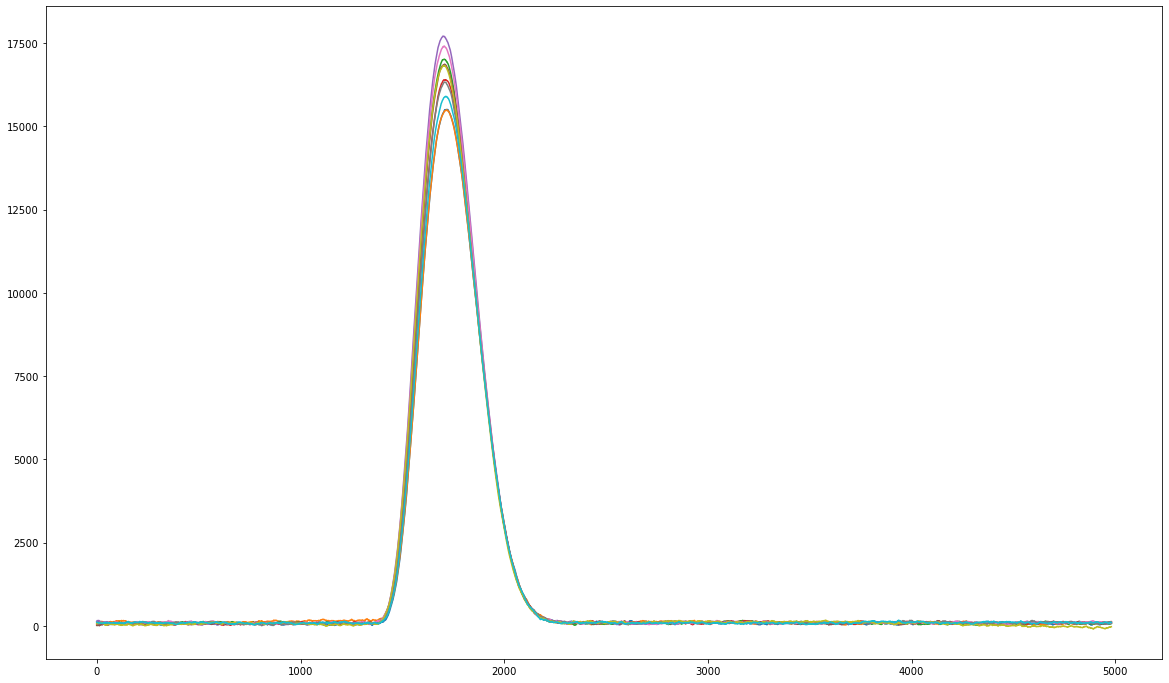

In [43]:
plt.figure(figsize=(20,12))
if PLOT_MAV_WAVE:
    for i in range(10):
        plt.plot(data_mav[i])
    plt.show()

#### **[Example: 0]** Plot integral of MAV waveforms

In [83]:
baseline_mask = np.arange(data_mav.shape[1])
baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

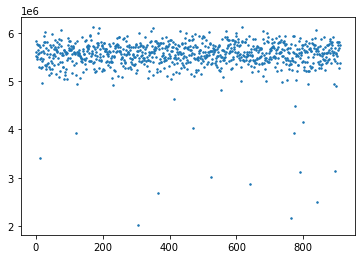

In [85]:
plt.plot(data_mav_int, "o", markersize=1.5)
plt.show()

#### **[Example: 0]** Plot of filtered integrals of waveforms

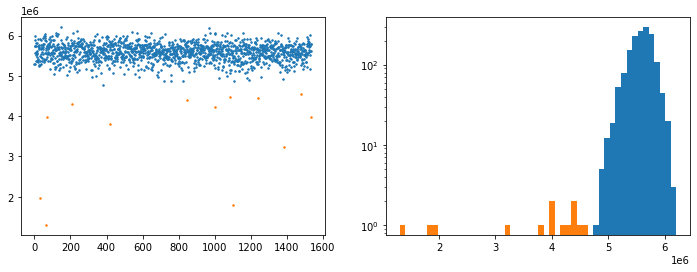

In [75]:
data_mav_int_mean = np.mean(data_mav_int)
data_mav_int_var  = np.std(data_mav_int)

mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
mask_f = np.logical_not(mask_t)

fig=plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)

plt.subplot(1,2,2)
plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
plt.yscale("log")
plt.show()

### Now for every angle

In [95]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []
norms     = []
ev_norms  = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    os.chdir(d)
    
    #######################################################################
    # TAKE DIRECTION FROM DIR NAME
    #######################################################################
    if "DC" in d:
        sign = -1
    elif "SC" in d:
        sign = +1
    else:
        sign = 0
    #######################################################################

    #######################################################################
    # TAKE DATA FROM run FILE
    #######################################################################
    file = open("run")
    line = file.readlines()
    for l in line:
        if (l.startswith("n_segments")):
            n_seg = int(l.split('=')[1].strip())
            pico_seg.append(n_seg)
    file.close()
    
    steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) - SC
    #######################################################################
    
    #######################################################################
    # TAKE DATA FROM run_BlockTimes.txt
    #######################################################################
    times  = np.loadtxt("run_BlockTimes.txt")
    blocks = times.shape[0]
    events = blocks * n_seg
    t      = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])

    pico_step.append(steps)
    pico_rad.append(steps * 0.9 * np.pi / 180.0)
    pico_deg.append(steps * 0.9)
    pico_t.append(t)
    pico_ev.append(events)
    pico_r.append(events / t * 3600)
    #######################################################################
    
    #######################################################################
    # COMPUTE ERRORS
    #######################################################################
    pico_step_err.append(1.0 / np.sqrt(12.0))
    pico_rad_err .append(1.0 / np.sqrt(12.0) * 0.9 * np.pi / 180.0)
    pico_deg_err .append(1.0 / np.sqrt(12.0) * 0.9)
    pico_ev_err  .append(np.sqrt(events))
    pico_r_err   .append(np.sqrt(events) / t * 3600)
    #######################################################################

    
    #######################################################################
    # TAKE DATA FROM ALL WAVEFORMS
    #######################################################################
    if WAVE2NUMPY:
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        if REJECT_3SIGMA:
            mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
            mask_f = np.logical_not(mask_t)
        else:
            mask_t = np.ones(data_mav_int.shape, dtype=bool)
            mask_f = np.logical_not(mask_t)

        if PLOT_WAVE:
            fig=plt.figure(figsize=(12, 4))
            plt.subplot(1,2,1)
            if mask_f.shape[0] != 0:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
            else:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.title(d)

            plt.subplot(1,2,2)
            if mask_f.shape[0] != 0:
                plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
            else:
                plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
            plt.yscale("log")
            plt.title(d)
            plt.show()
    #######################################################################

    os.chdir(DATA_PATH)

14_SX
8_DX
5_DX
6_DX
13_DX
12_SX
1_DX
5_SX
2_SX
8_SX
15_DX
13_SX
14_DX
9_SX
11_SX
2_DX
3_DX
4_DX
12_DX
9_DX
10_SX
16_SX
7_SX
4_SX
10_DX
11_DX
16_DX
3_SX
1_SX
0
15_SX
7_DX
6_SX


### Events distribution

In [97]:
col = palette.brewer['RdYlGn'][10]

In [99]:
angles, events, err_angles, err_events = (list(t) for t in zip(*sorted(zip(angles, events, err_angles, err_events))))

<ErrorbarContainer object of 3 artists>

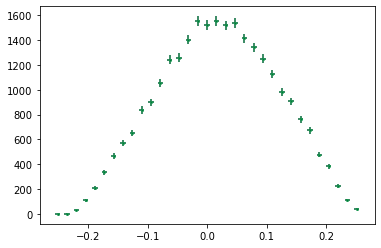

In [102]:
plt.errorbar(angles, events,
             xerr=err_angles, yerr=err_events,
             fmt='o', markerfacecolor=col[0],
             color=col[1], ecolor=col[0],
             label="data",alpha=1,markersize=2)

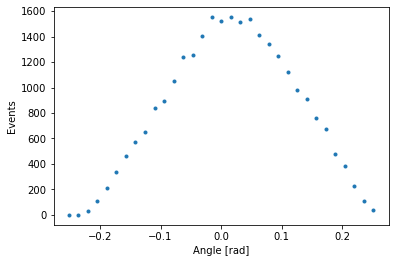

In [93]:
plt.plot(angles, events, "o", markersize=3)
plt.xlabel("Angle [rad]")
plt.ylabel("Events")
plt.show()

In [11]:
np.vstack((np.round(np.array(angles)*180/np.pi,2),np.array(events), np.array(angles))).T

array([[-1.26000000e+01,  2.80000000e+01, -2.19911486e-01],
       [ 7.20000000e+00,  9.82000000e+02,  1.25663706e-01],
       [ 4.50000000e+00,  1.34200000e+03,  7.85398163e-02],
       [ 5.40000000e+00,  1.25100000e+03,  9.42477796e-02],
       [ 1.17000000e+01,  3.82000000e+02,  2.04203522e-01],
       [-1.08000000e+01,  2.10000000e+02, -1.88495559e-01],
       [ 9.00000000e-01,  1.55200000e+03,  1.57079633e-02],
       [-4.50000000e+00,  1.05400000e+03, -7.85398163e-02],
       [-1.80000000e+00,  1.40400000e+03, -3.14159265e-02],
       [-7.20000000e+00,  6.51000000e+02, -1.25663706e-01],
       [ 1.35000000e+01,  1.11000000e+02,  2.35619449e-01],
       [-1.17000000e+01,  1.09000000e+02, -2.04203522e-01],
       [ 1.26000000e+01,  2.27000000e+02,  2.19911486e-01],
       [-8.10000000e+00,  5.69000000e+02, -1.41371669e-01],
       [-9.90000000e+00,  3.35000000e+02, -1.72787596e-01],
       [ 1.80000000e+00,  1.51900000e+03,  3.14159265e-02],
       [ 2.70000000e+00,  1.54000000e+03